In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

import bars
import c
import signals
import u

# Data Generation

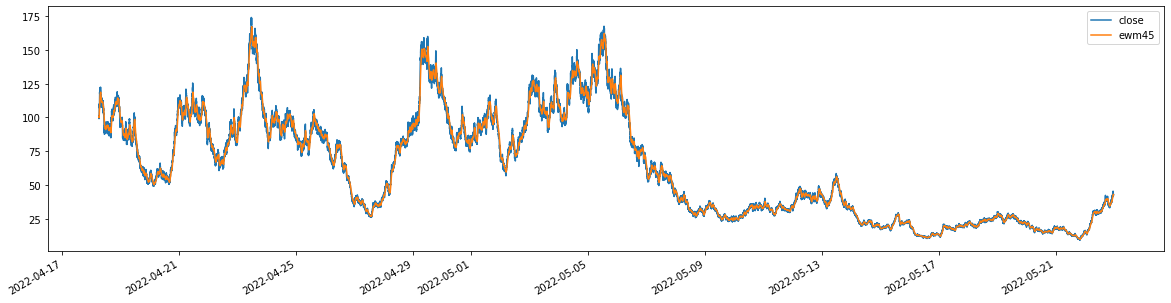

In [3]:
plt.rcParams["figure.figsize"] = (20, 5)

data = u.create_price_data(theta=0.0001, start_price=100, n_samples=50000)
data["ewm45"] = data["close"].ewm(span=45).mean()
data["close"].plot.line()
data["ewm45"].plot.line()
plt.legend()

## Zoom in of Price

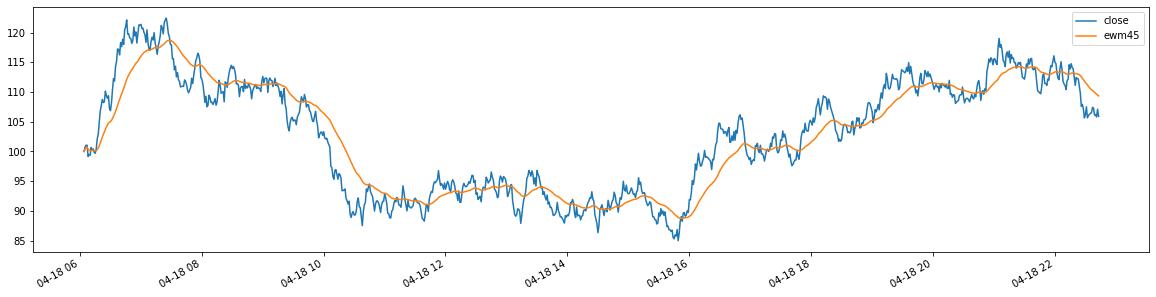

In [4]:
data.iloc[
    :1000,
]["close"].plot.line()
data.iloc[
    :1000,
]["ewm45"].plot.line()
plt.legend()

In [5]:
ewm45 = data["ewm45"]
curr = data["close"]
prev = data["close"].shift(1)
cross_up = (curr > ewm45) & (prev < ewm45)
cross_down = (curr < ewm45) & (prev > ewm45)
data["dir"] = (
    cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
)
data["trade"] = cross_up | cross_down
data.head(10)

,close,ewm45,dir,trade
2022-04-18 06:04:06.953678,100.00,100.000000,0,False
2022-04-18 06:05:06.953678,100.75,100.383333,1,True
2022-04-18 06:06:06.953678,101.05,100.615504,0,False
2022-04-18 06:07:06.953678,101.04,100.728805,0,False
2022-04-18 06:08:06.953678,99.15,100.384367,-1,True
2022-04-18 06:09:06.953678,99.50,100.220122,0,False
2022-04-18 06:10:06.953678,99.36,100.080272,0,False
2022-04-18 06:11:06.953678,100.67,100.165952,1,True
2022-04-18 06:12:06.953678,100.21,100.171760,0,False
2022-04-18 06:13:06.953678,100.42,100.201835,0,False


# Triple Barrier

In [6]:
resampled = data.resample("H")
target = np.mean((resampled["close"].last() / resampled["close"].first()).std()) * 0.5
price_target = 1
stop_loss = 1
vertical_barrier = np.timedelta64(1, "h")

target

0.038216277234419574

In [7]:
indices = data.loc[data["trade"]].index

diff = np.timedelta64(30, "m")
last = indices[0]
new_indices = [last]
for i in indices:
    if last + diff < i:
        new_indices.append(i)
        last = i

indices = new_indices

barriers = signals.get_price_target_stop_loss_indices(
    data,
    indices,
    target=target,
    side=data.loc[indices, "dir"],
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)
barriers = signals.add_profit_target_stop_loss_outcome(barriers)
barriers.head()

,pt_dt,sl_dt,side,pt_sl,pt
2022-04-18 06:05:06.953678,2022-04-18 06:19:06.953678,NaT,1,1,True
2022-04-18 07:09:06.953678,2022-04-18 07:35:06.953678,2022-04-18 07:23:06.953678,-1,-1,False
2022-04-18 07:54:06.953678,NaT,2022-04-18 08:02:06.953678,1,-1,False
2022-04-18 08:25:06.953678,2022-04-18 09:24:06.953678,NaT,-1,1,True
2022-04-18 08:59:06.953678,NaT,2022-04-18 09:23:06.953678,1,-1,False


In [8]:
last = barriers.index[0]
plot_indices = [last]
for i in barriers.index:
    if last + vertical_barrier < i:
        plot_indices.append(i)
        last = i

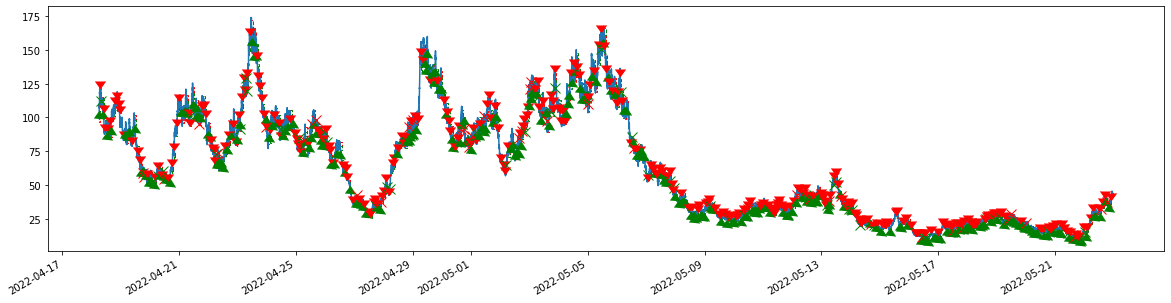

In [9]:
import plt_utils

fig, ax = plt.subplots()
data["close"].plot.line()

plt_utils.plot_triple_barrier(
    ax,
    data,
    barriers.loc[plot_indices],
    target=target,
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)

# Classifier

In [10]:
train = barriers.merge(data, how="left", left_index=True, right_index=True)
train.head()

,pt_dt,sl_dt,side,pt_sl,pt,close,ewm45,dir,trade
2022-04-18 06:05:06.953678,2022-04-18 06:19:06.953678,NaT,1,1,True,100.75,100.383333,1,True
2022-04-18 07:09:06.953678,2022-04-18 07:35:06.953678,2022-04-18 07:23:06.953678,-1,-1,False,117.04,117.065798,-1,True
2022-04-18 07:54:06.953678,NaT,2022-04-18 08:02:06.953678,1,-1,False,115.30,114.360485,1,True
2022-04-18 08:25:06.953678,2022-04-18 09:24:06.953678,NaT,-1,1,True,110.77,111.202154,-1,True
2022-04-18 08:59:06.953678,NaT,2022-04-18 09:23:06.953678,1,-1,False,111.75,111.118208,1,True


In [11]:
model = RandomForestClassifier(n_estimators=100, max_depth=20)
cols = ["close", "ewm45"]
model.fit(train[cols], train["pt"])

RandomForestClassifier(max_depth=20)

## Test

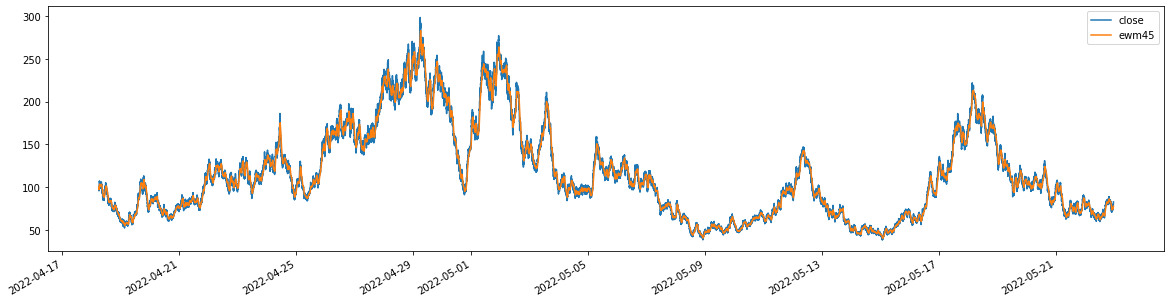

In [12]:
test = u.create_price_data(theta=0.0001, start_price=100, n_samples=50000)
test["ewm45"] = test["close"].ewm(span=45).mean()
ewm45 = test["ewm45"]
curr = test["close"]
prev = test["close"].shift(1)
cross_up = (curr > ewm45) & (prev < ewm45)
cross_down = (curr < ewm45) & (prev > ewm45)
test["dir"] = (
    cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
)
test["trade"] = cross_up | cross_down
test["close"].plot.line()
test["ewm45"].plot.line()
plt.legend()

In [13]:
pred = test.loc[test["trade"] == True].index

diff = np.timedelta64(5, "m")
last = pred[0]
new_indices = [last]
for i in pred:
    if last + diff < i:
        new_indices.append(i)
        last = i

pred = new_indices
pred = signals.get_price_target_stop_loss_indices(
    test,
    pred,
    target=target,
    side=test.loc[pred, "dir"],
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)
pred = signals.add_profit_target_stop_loss_outcome(pred)
pred["pred"] = model.predict(test.loc[pred.index][cols])

pred.head()

,pt_dt,sl_dt,side,pt_sl,pt,pred
2022-04-18 06:05:13.521647,NaT,2022-04-18 06:20:13.521647,-1,-1,False,True
2022-04-18 06:11:13.521647,2022-04-18 06:20:13.521647,NaT,1,1,True,True
2022-04-18 06:17:13.521647,2022-04-18 06:20:13.521647,NaT,1,1,True,True
2022-04-18 06:38:13.521647,NaT,NaT,-1,0,False,False
2022-04-18 06:50:13.521647,NaT,2022-04-18 07:13:13.521647,1,-1,False,False


In [14]:
info = pred.merge(test, how="left", left_index=True, right_index=True)
info.loc[info["pred"] == True].head()

,pt_dt,sl_dt,side,pt_sl,pt,pred,close,ewm45,dir,trade
2022-04-18 06:05:13.521647,NaT,2022-04-18 06:20:13.521647,-1,-1,False,True,98.41,99.187333,-1,True
2022-04-18 06:11:13.521647,2022-04-18 06:20:13.521647,NaT,1,1,True,True,97.65,97.248013,1,True
2022-04-18 06:17:13.521647,2022-04-18 06:20:13.521647,NaT,1,1,True,True,98.91,98.409949,1,True
2022-04-18 07:00:13.521647,NaT,NaT,1,0,False,True,102.06,101.969708,1,True
2022-04-18 07:06:13.521647,NaT,2022-04-18 08:05:13.521647,-1,-1,False,True,101.64,102.034166,-1,True


<AxesSubplot:>

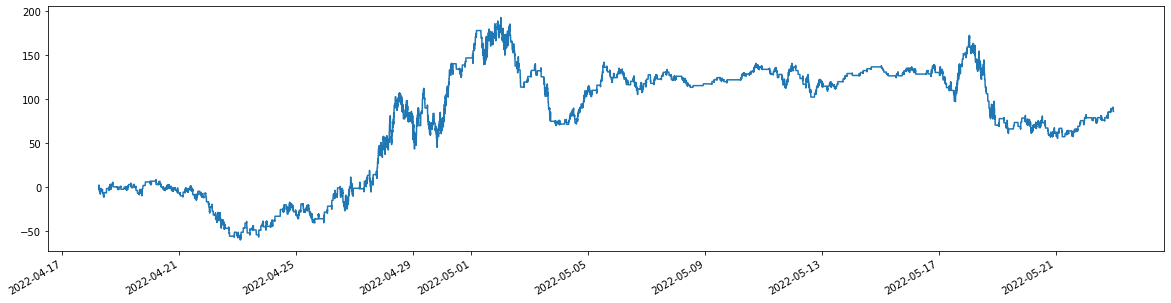

In [15]:
u_pnl = np.zeros(len(test.index))
r_pnl = np.zeros(len(test.index))
entry = None
pred_ = None
trades = 0
for e, (i, r) in enumerate(test.iterrows()):
    if entry is not None:
        if (
            i == pred_["pt_dt"]
            or i == pred_["sl_dt"]
            or i > pred_.name + vertical_barrier
        ):
            r_pnl[e] += (r["close"] - entry["close"]) * entry["dir"]
            entry = None
            pred_ = None
        else:
            u_pnl[e] = (r["close"] - entry["close"]) * entry["dir"]
    elif entry is None and r["trade"] and i in pred.index and pred.loc[i, "pred"]:
        entry = i
        entry = r
        pred_ = pred.loc[i]
        trades += 1

r_pnl = r_pnl.cumsum()
test["pnl"] = u_pnl + r_pnl
test["pnl"].plot.line()